In [14]:
# %pip install numpy
# %pip install ipywidgets
# %pip install torch
# %pip install scikit-learn
# %pip install tensorflow
# %pip install torchvision
# %pip install opencv-python
# %pip install matplotlib
# %pip install kagglehub
# %pip install monai
# %pip install ingenii-quantum-hybrid-networks

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from monai.transforms import ScaleIntensity
import kagglehub
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from ingenii_quantum.hybrid_networks.layers import QuantumFCLayer


#### Download latest version https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/data

In [3]:
path = kagglehub.dataset_download(r"navoneel/brain-mri-images-for-brain-tumor-detection")
# print("Path to dataset files:", path)

#### Define dataset paths
#### !!! Remove .DS_Store from folders

In [4]:
# !rm -rf {path}/brain_tumor_dataset/yes/.DS_Store
# !rm -rf {path}/brain_tumor_dataset/no/.DS_Store

In [4]:
dataset_path_tumor = f'{path}/brain_tumor_dataset/yes'
dataset_path_norma = f'{path}/brain_tumor_dataset/no'

#### Count files in directory

In [4]:
def count_images(directory):
    return len([f for f in os.listdir(directory) if f.endswith(('.jpg', '.JPG', '.png', '.jpeg'))])

print("Length dataset_path_tumor:", count_images(dataset_path_tumor))
print("Length dataset_path_norma:", count_images(dataset_path_norma))

Length dataset_path_tumor: 155
Length dataset_path_norma: 98


#### Check data

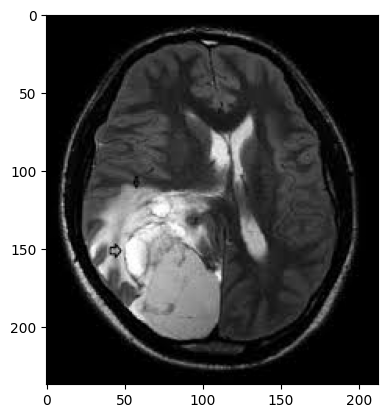

In [5]:
mri_image = cv2.imread(f'{dataset_path_tumor}/Y245.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(mri_image, cmap='gray')

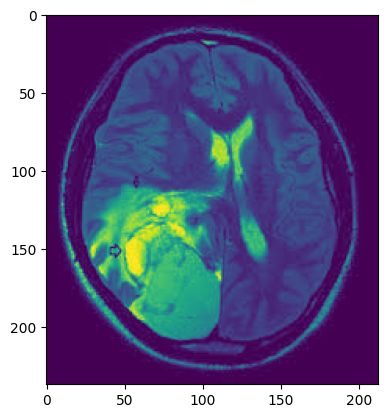

In [6]:
transform_img = ScaleIntensity(minv=0.0, maxv=1.0)
mri_image_scaled = transform_img(mri_image)
colored_mri = cm.viridis(mri_image_scaled)
plt.imshow(colored_mri)

#### Load and preprocess the images

In [7]:
img_size = (128, 128)

def load_images_from_folder(folder, label, target_size=img_size):
    """
    Loads images from a given folder and resizes them to the specified target size.
    Converts images to RGB and stores them as numpy arrays (3D).

    Args:
        folder (str): Path to the folder containing images.
        label (int): Label associated with the images in the folder.
        target_size (tuple): Target size to which images will be resized (width, height).

    Returns:
        tuple: A list of image data and their corresponding labels.
    """
    data, labels = [], []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path).convert("RGB").resize(target_size)
            data.append(np.array(img))
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")
    return np.array(data), np.array(labels)


def load_and_limit_data(path, label, num_samples, target_size=img_size):
    """
    Loads and limits the number of images from a folder to a specified number of samples.
    Ensures images are resized to the specified target size.

    Args:
        path (str): Path to the folder containing images.
        label (int): Label associated with the images in the folder.
        num_samples (int): Maximum number of samples to load.
        target_size (tuple): Target size to which images will be resized (width, height).

    Returns:
        tuple: A numpy array of limited image data and their corresponding labels.
    """
    data, labels = load_images_from_folder(path, label, target_size)
    indices = np.random.choice(len(data), min(num_samples, len(data)), replace=False)
    data = data[indices]
    labels = labels[indices]
    return data, labels

#### Display images for train

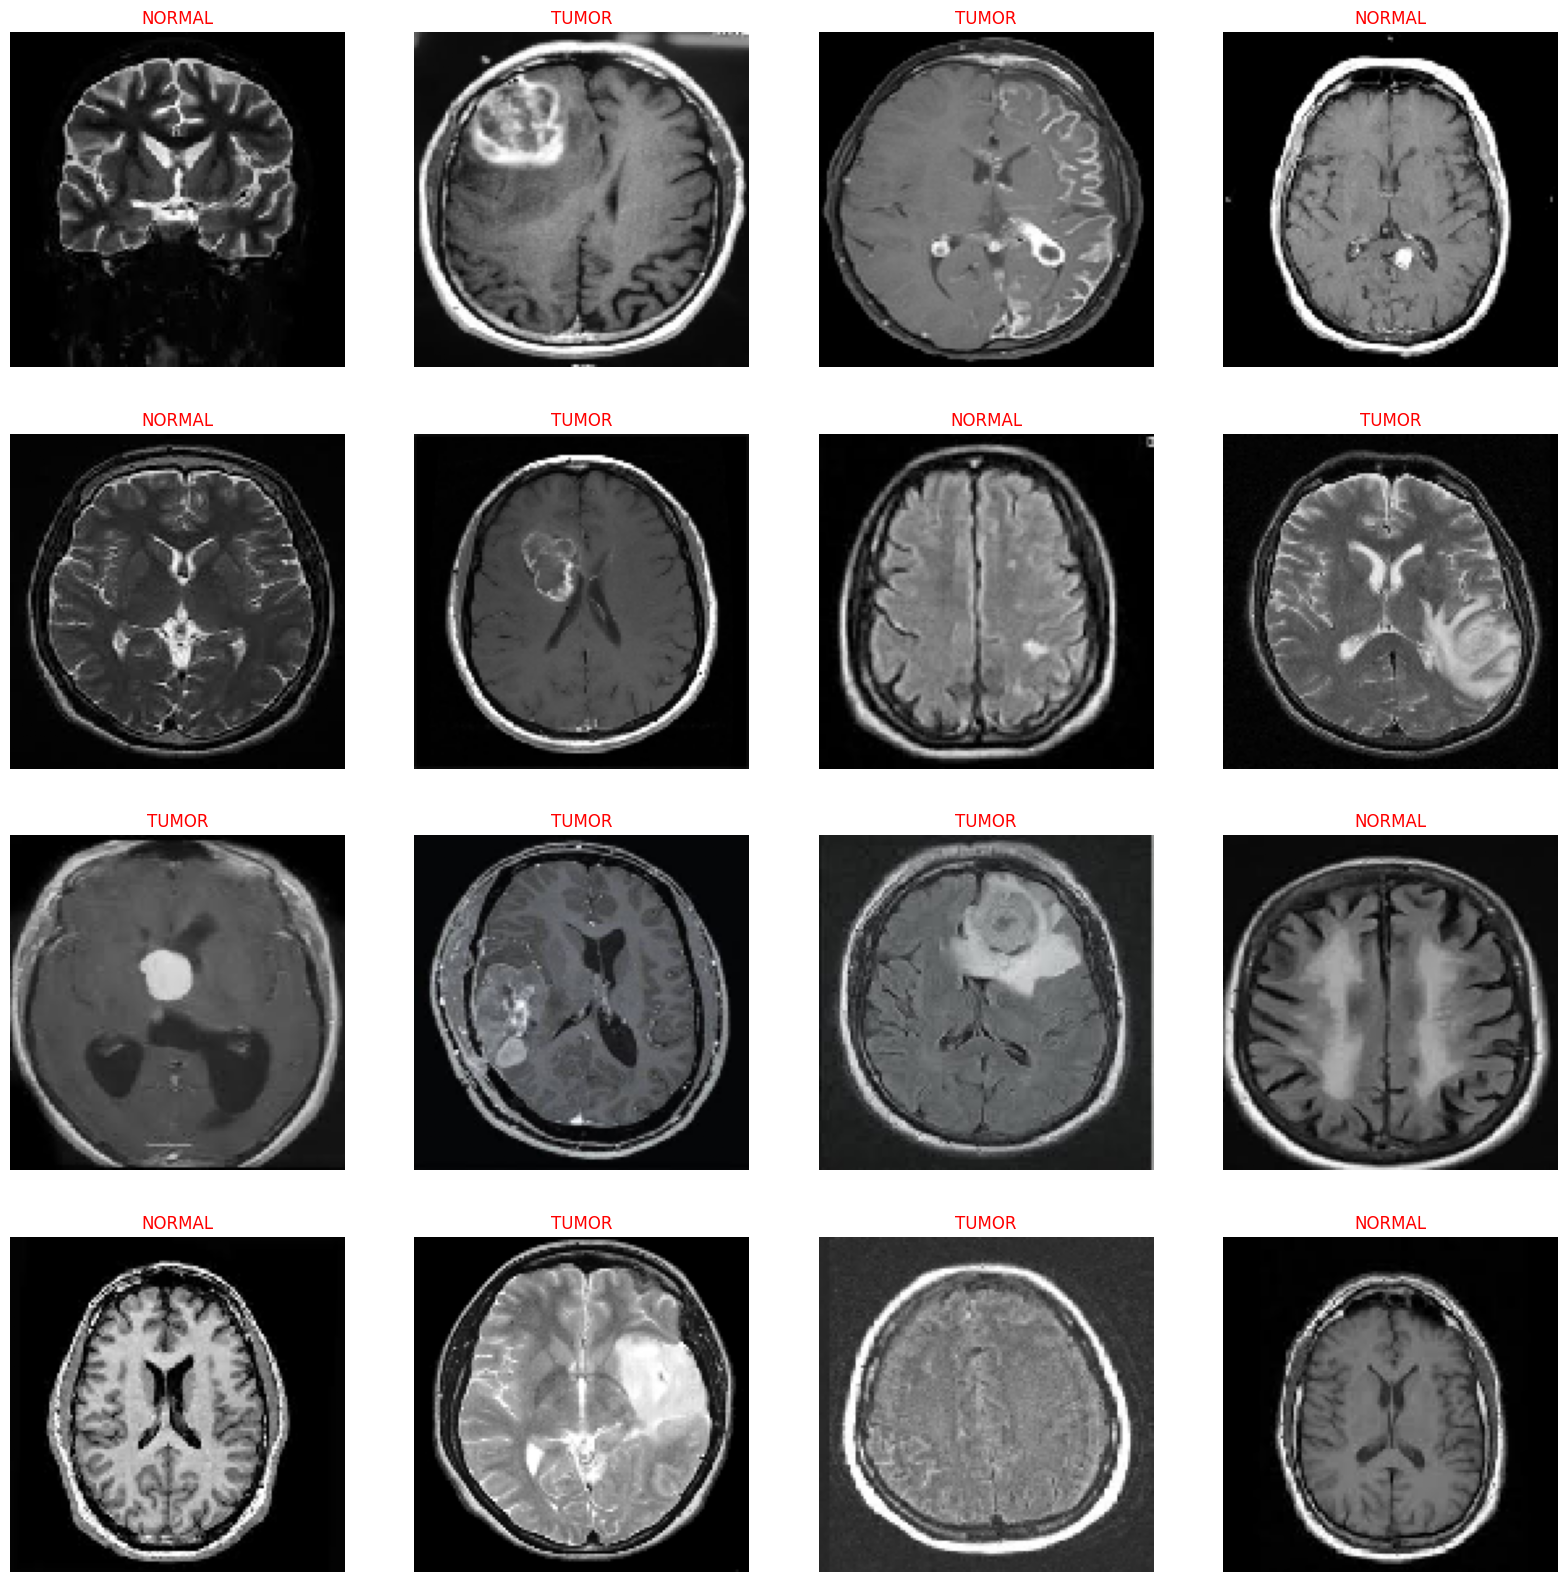

In [8]:
def load_file_paths_and_labels(directory, label):
    filepaths = [os.path.join(directory, fname) for fname in os.listdir(directory) if os.path.isfile(os.path.join(directory, fname))]
    labels = [label] * len(filepaths)
    return filepaths, labels

tumor_filepaths, tumor_labels = load_file_paths_and_labels(dataset_path_tumor, 'TUMOR')
normal_filepaths, normal_labels = load_file_paths_and_labels(dataset_path_norma, 'NORMAL')

all_filepaths = tumor_filepaths + normal_filepaths
all_labels = tumor_labels + normal_labels

combined = list(zip(all_filepaths, all_labels))
np.random.shuffle(combined)
all_filepaths, all_labels = zip(*combined)

label_to_index = {'TUMOR': 0, 'NORMAL': 1}
categorical_labels = np.array([label_to_index[label] for label in all_labels])

def scalar(img):
    return img

def custom_generator(filepaths, labels, batch_size, img_size, preprocessing_function=None):
    while True:
        for i in range(0, len(filepaths), batch_size):
            batch_filepaths = filepaths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]
            
            images = []
            for filepath in batch_filepaths:
                img = load_img(filepath, target_size=img_size)
                img_array = img_to_array(img)
                if preprocessing_function:
                    img_array = preprocessing_function(img_array)
                images.append(img_array)
            
            yield np.array(images), np.array(batch_labels)

img_size = img_size
batch_size = 32

train_gen = custom_generator(all_filepaths, categorical_labels, batch_size, img_size, preprocessing_function=scalar)

images, labels = next(train_gen)

classes = list(label_to_index.keys())

plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    class_index = labels[i]
    class_name = classes[class_index]
    plt.title(class_name, color='red', fontsize=12)
    plt.axis('off')

plt.show()

#### Get training and testing data

In [9]:
tumor_data, tumor_labels = load_and_limit_data(dataset_path_tumor, label=1, num_samples=98)
normal_data, normal_labels = load_and_limit_data(dataset_path_norma, label=0, num_samples=155)

all_data = np.concatenate([tumor_data, normal_data], axis=0)
all_labels = np.concatenate([tumor_labels, normal_labels], axis=0)

X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.2, random_state=42)
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

#### Quantum layer

In [10]:
num_qubits = 8

qnn_layer = QuantumFCLayer(
    input_size=num_qubits,
    n_layers=1,
    encoding='qubit',
    ansatz=1,
    observables=["Z" + "I" * (num_qubits - 1)],
    backend='default.qubit'
).create_layer(type_layer='torch')

#### Setting quantum model

In [11]:
class QuantumCNN(nn.Module):
    def __init__(self, num_classes=2, num_qubits=8):
        super(QuantumCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Global pooling and flattening
        self.global_pool = nn.AdaptiveAvgPool2d((2, 2))
        self.flattened_size = 128 * 2 * 2

        self.quantum_layer = qnn_layer
        
        # Fully connected layers
        self.fc1 = nn.Linear(513, 512) 
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        x = self.global_pool(x)
        
        x = x.reshape(x.size(0), -1)

        quantum_input = x[:, :8]
        
        q_out = self.quantum_layer(quantum_input)
        
        # Concatenate classical CNN features with quantum output
        x = torch.cat((x, q_out), dim=1)

        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        
        x = F.relu(self.fc2(x))
        
        x = self.fc3(x)
        
        return x


#### Initialize the model

In [12]:
quantum_model = QuantumCNN(num_classes=2)

#### Training function

In [13]:
def fit_quantum_model(model, X_train, y_train, epochs=20, batch_size=32, patience=5):
    """
    Trains the QuantumCNN model using the provided training data.

    Args:
        model: QuantumCNN model instance to be trained.
        X_train (numpy array): Training image data of shape (num_samples, 128, 128, 3).
        y_train (numpy array): Training labels.
        epochs (int): Number of epochs for training.
        batch_size (int): Batch size for training.
        patience (int): Early stopping patience (not implemented in this version).

    Returns:
        dict: Training history containing loss and accuracy per epoch.
    """
    model.train()
    history = {'loss': [], 'accuracy': []}

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    dataset = TensorDataset(X_train_tensor, y_train_tensor)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0

        for X_batch, y_batch in data_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, dim=1)
            acc = (predicted == y_batch).float().mean().item()
            epoch_accuracy += acc

        avg_epoch_loss = epoch_loss / len(data_loader)
        avg_epoch_accuracy = epoch_accuracy / len(data_loader)
        history['loss'].append(avg_epoch_loss)
        history['accuracy'].append(avg_epoch_accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_epoch_loss:.4f}, Accuracy: {avg_epoch_accuracy:.4f}")

    return history

#### Training the model

In [14]:
quantum_history = fit_quantum_model(quantum_model, X_train, y_train, epochs=50)

Epoch [1/50], Loss: 0.7486, Accuracy: 0.5366
Epoch [2/50], Loss: 0.6788, Accuracy: 0.5991
Epoch [3/50], Loss: 0.6380, Accuracy: 0.6652
Epoch [4/50], Loss: 0.5893, Accuracy: 0.6723
Epoch [5/50], Loss: 0.5221, Accuracy: 0.7625
Epoch [6/50], Loss: 0.5302, Accuracy: 0.7259
Epoch [7/50], Loss: 0.5612, Accuracy: 0.7375
Epoch [8/50], Loss: 0.5054, Accuracy: 0.7696
Epoch [9/50], Loss: 0.4798, Accuracy: 0.7670
Epoch [10/50], Loss: 0.4957, Accuracy: 0.8089
Epoch [11/50], Loss: 0.5184, Accuracy: 0.7759
Epoch [12/50], Loss: 0.5402, Accuracy: 0.7393
Epoch [13/50], Loss: 0.4728, Accuracy: 0.7500
Epoch [14/50], Loss: 0.4892, Accuracy: 0.7696
Epoch [15/50], Loss: 0.4419, Accuracy: 0.7964
Epoch [16/50], Loss: 0.4643, Accuracy: 0.8107
Epoch [17/50], Loss: 0.4232, Accuracy: 0.8161
Epoch [18/50], Loss: 0.4246, Accuracy: 0.8330
Epoch [19/50], Loss: 0.4095, Accuracy: 0.8080
Epoch [20/50], Loss: 0.4244, Accuracy: 0.8330
Epoch [21/50], Loss: 0.3895, Accuracy: 0.8268
Epoch [22/50], Loss: 0.4166, Accuracy: 0.81

#### Plotting accuracy and loss

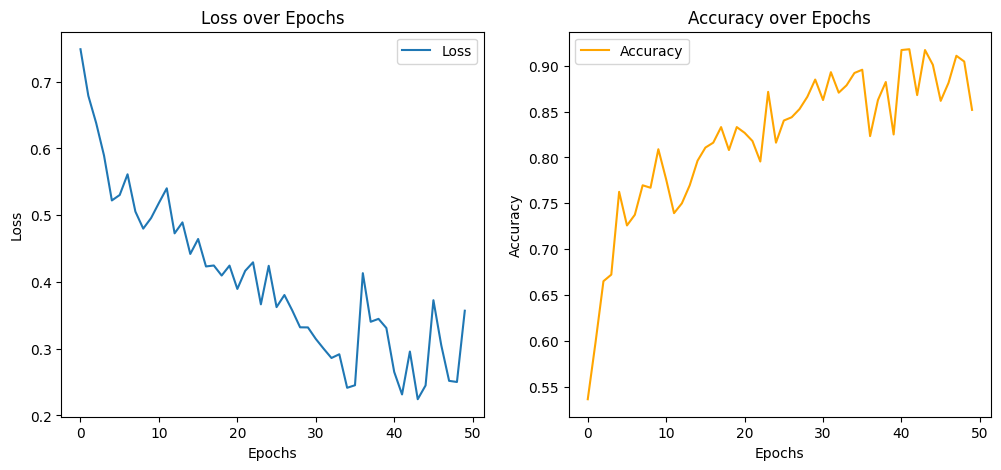

In [15]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(quantum_history['loss'], label='Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(quantum_history['accuracy'], label='Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### Evaluate performance

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
quantum_model.to(device)

y_train_indices = torch.tensor(y_train, dtype=torch.long).to(device)  # Shape: (156,)
y_test_indices = torch.tensor(y_test, dtype=torch.long).to(device)    # Shape: (40,)

quantum_model.eval()

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2).to(device)

with torch.no_grad():
    outputs = quantum_model(X_test_tensor)

y_pred = torch.argmax(outputs, dim=1).cpu().numpy()
y_test_labels = y_test_indices.cpu().numpy()

print(f"Test Accuracy: {metrics.accuracy_score(y_test_labels, y_pred) * 100:.2f}%")
print(metrics.classification_report(y_test_labels, y_pred, target_names=['Normal', 'Tumor']))


Test Accuracy: 75.00%
              precision    recall  f1-score   support

      Normal       0.80      0.63      0.71        19
       Tumor       0.72      0.86      0.78        21

    accuracy                           0.75        40
   macro avg       0.76      0.74      0.74        40
weighted avg       0.76      0.75      0.75        40



#### Compute evaluation metrics

In [26]:
if y_pred.ndim == 1:
    y_pred_labels = y_pred
else:
    y_pred_labels = torch.argmax(torch.tensor(y_pred), dim=1).numpy()

classification_rep = metrics.classification_report(y_test_labels, y_pred_labels, output_dict=True, zero_division=True)

conf_matrix = metrics.confusion_matrix(y_test_labels, y_pred_labels)

roc_auc = metrics.roc_auc_score(y_test_labels, y_pred_labels)

print("Classification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)
print(f"ROC AUC Score: {roc_auc}")

Classification Report:
 {'0': {'precision': 0.8, 'recall': 0.631578947368421, 'f1-score': 0.7058823529411765, 'support': 19.0}, '1': {'precision': 0.72, 'recall': 0.8571428571428571, 'f1-score': 0.782608695652174, 'support': 21.0}, 'accuracy': 0.75, 'macro avg': {'precision': 0.76, 'recall': 0.744360902255639, 'f1-score': 0.7442455242966752, 'support': 40.0}, 'weighted avg': {'precision': 0.758, 'recall': 0.75, 'f1-score': 0.7461636828644501, 'support': 40.0}}
Confusion Matrix:
 [[12  7]
 [ 3 18]]
ROC AUC Score: 0.744360902255639


#### Predicted probability for Positive Class

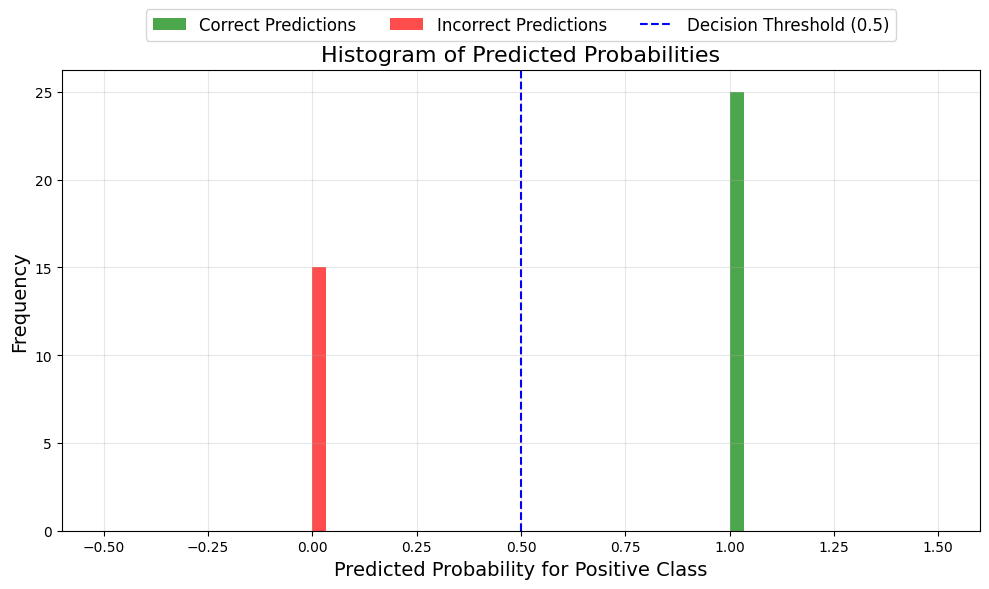

In [27]:
if isinstance(y_pred, np.ndarray):
    y_pred = torch.tensor(y_pred, dtype=torch.float32)

predictions = torch.round(y_pred)
correct_predictions = (predictions == 1)
incorrect_predictions = ~correct_predictions

correct_probs = y_pred[correct_predictions]
incorrect_probs = y_pred[incorrect_predictions]

plt.figure(figsize=(10, 6))

plt.hist(
    correct_probs.numpy(), 
    bins=30, 
    alpha=0.7, 
    color='green', 
    label='Correct Predictions'
)

plt.hist(
    incorrect_probs.numpy(), 
    bins=30, 
    alpha=0.7, 
    color='red', 
    label='Incorrect Predictions'
)

plt.axvline(0.5, color='blue', linestyle='--', label='Decision Threshold (0.5)', linewidth=1.5)

plt.title('Histogram of Predicted Probabilities', fontsize=16)
plt.xlabel('Predicted Probability for Positive Class', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


#### PCA of model prediction

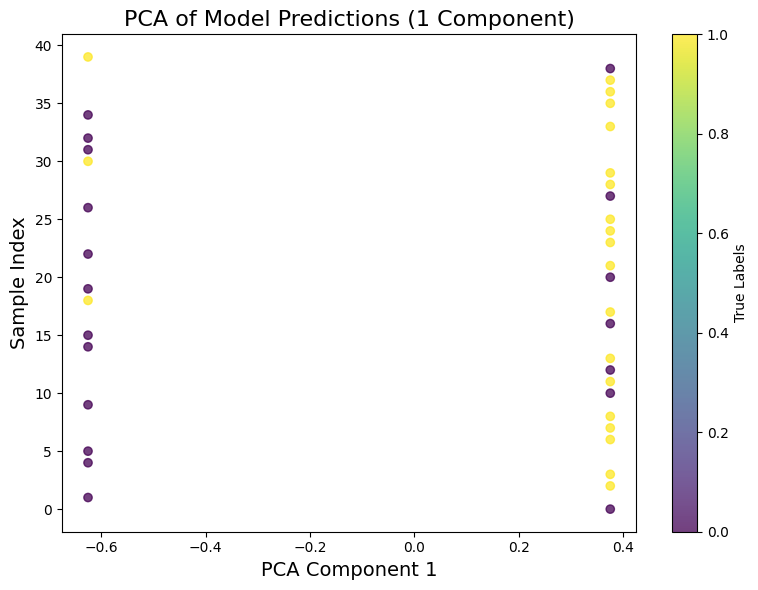

In [30]:
labels_test_reshaped = y_pred.reshape(-1, 1)

pca = PCA(n_components=1)
features_pca = pca.fit_transform(labels_test_reshaped)

plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], range(len(features_pca)), c=y_test_labels, cmap='viridis', alpha=0.75)

plt.colorbar(label='True Labels')
plt.title('PCA of Model Predictions (1 Component)', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('Sample Index', fontsize=14)

plt.tight_layout()
plt.show()

#### Plot the confusion matrix

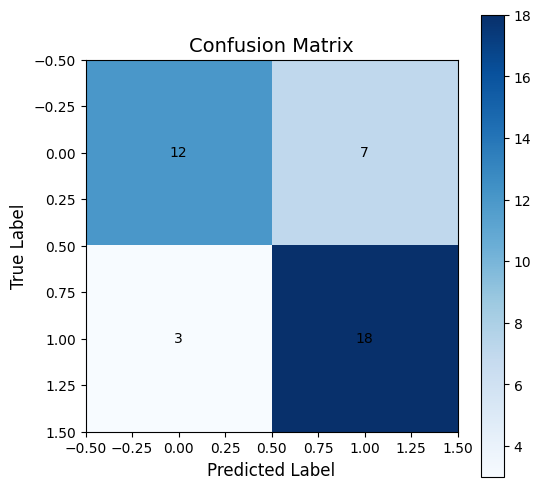

In [31]:
plt.figure(figsize=(6, 6))
plt.title("Confusion Matrix", fontsize=14)
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues, aspect='equal')
plt.colorbar()

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, f"{conf_matrix[i, j]}", ha="center", va="center", color="black", fontsize=10)

plt.show()